In [2]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
# Load the datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Train data size:', train.shape)
print('Test data size:', test.shape)

Train data size: (42000, 785)
Test data size: (28000, 784)


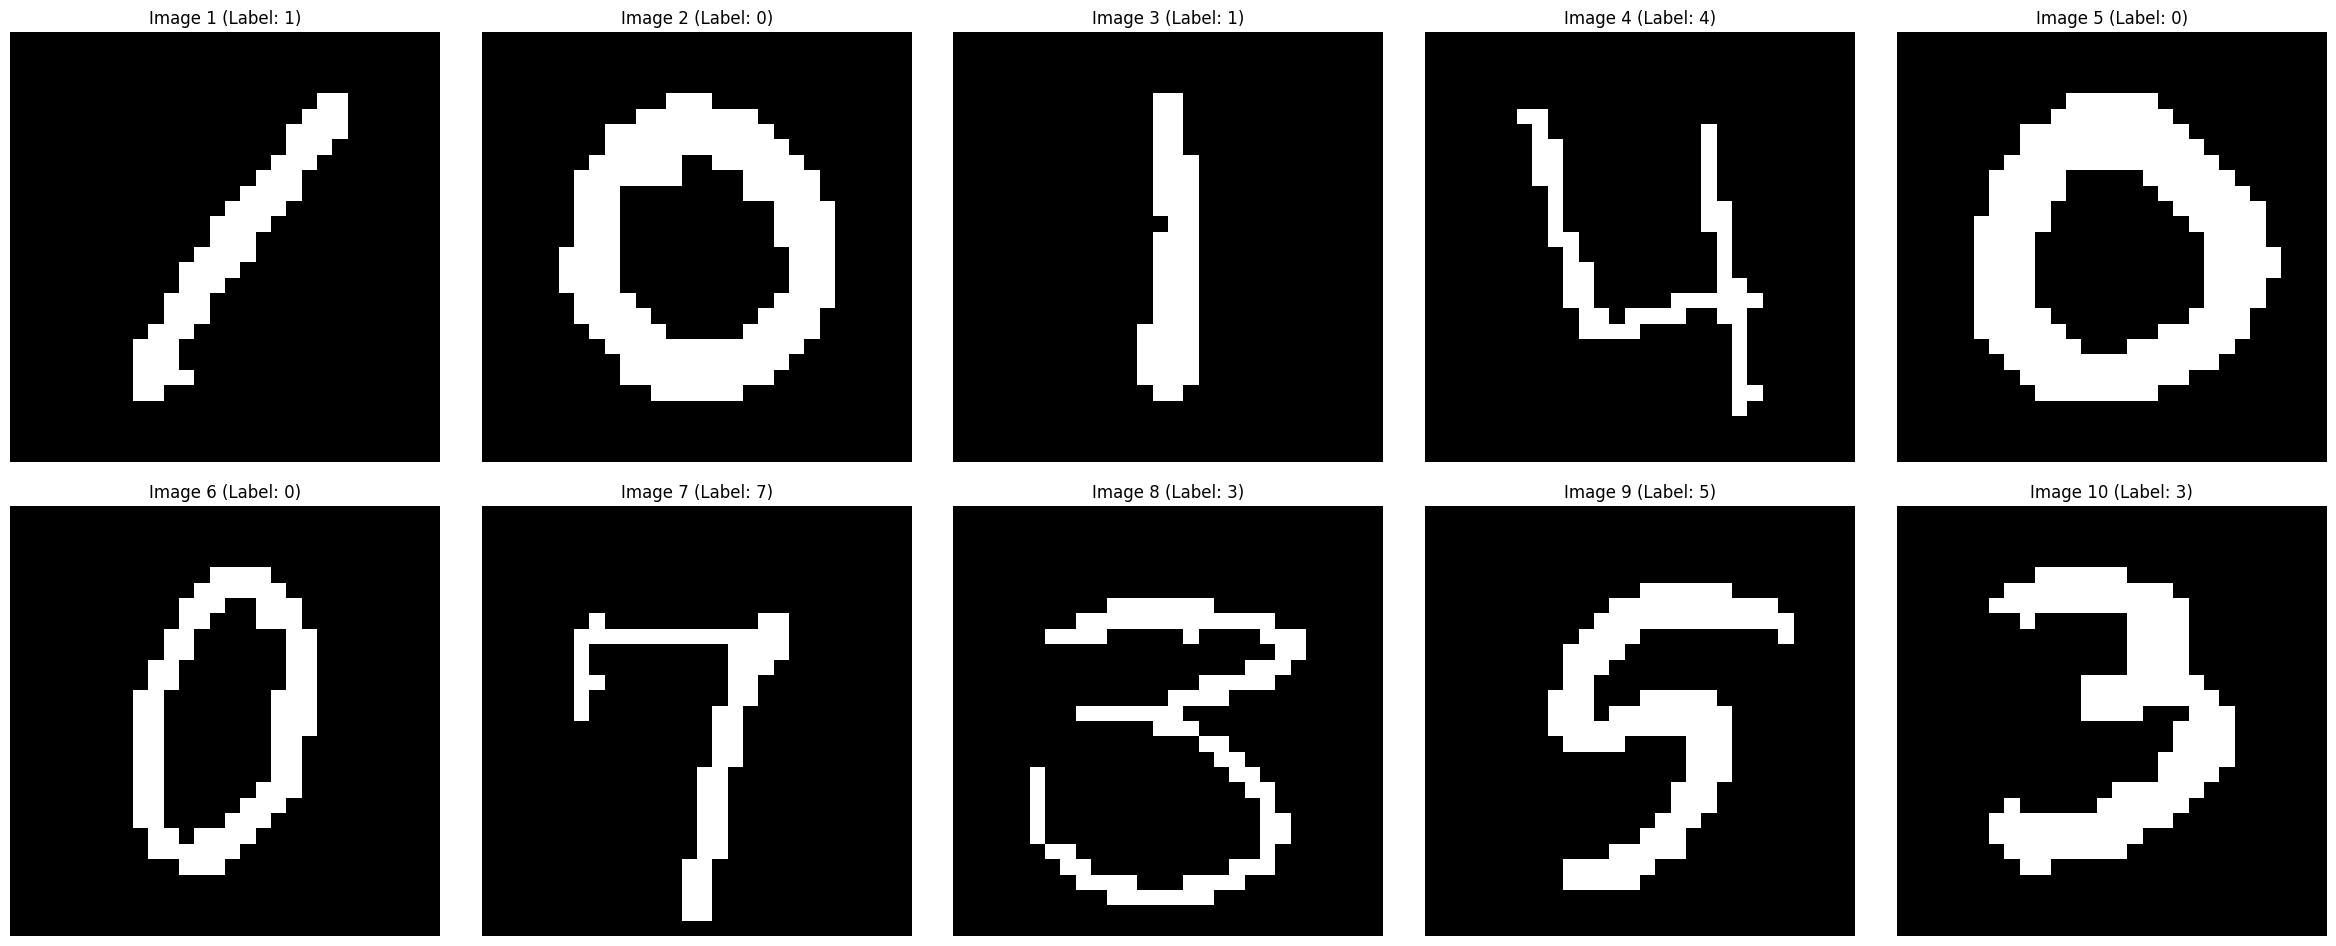

In [4]:
# Visualize some samples from the training data
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
for i in range(10):
    image_data = train.iloc[i, 1:].values
    label = train.iloc[i, 0]
    image_data = image_data.reshape(28, 28, 1).astype(np.uint8)
    _, image_data = cv2.threshold(image_data, 120, 255, cv2.THRESH_BINARY)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image_data, cmap='gray')
    axes[row, col].set_title(f'Image {i+1} (Label: {label})')
    axes[row, col].axis('off')
plt.subplots_adjust(top=0.85, bottom=0.1)
plt.tight_layout(pad=3.0)
plt.show()

In [5]:
# Function to apply thresholding
def apply_thresholding(x):
    thresholded_images = np.zeros_like(x)
    for i in range(x.shape[0]):
        image_data = x[i]
        image_data = image_data.reshape(28, 28, 1).astype(np.uint8)
        _, image_data = cv2.threshold(image_data, 120, 255, cv2.THRESH_BINARY)
        thresholded_images[i] = image_data.reshape(28, 28, 1)
    return thresholded_images


In [6]:
# Prepare training and testing data
X = train.drop(columns='label')
y = train['label']
X_train = np.reshape(X.values, (-1, 28, 28, 1))  # Ensure values are used for reshaping
X_train_th = apply_thresholding(X_train)
X_train_th = X_train_th.astype("float32") / 255.0
y_train = to_categorical(y)

In [7]:
# Prepare test data
test = np.reshape(test.values, (-1, 28, 28, 1))
test = apply_thresholding(test)
test = test.astype("float32") / 255.0

In [8]:
# Function to create the CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
foldNo = 1
accuracyPerFold = []

# K-Fold Cross-Validation
for trainIndex, valIndex in kf.split(X_train_th):
    print(f'Fold {foldNo}')
    print(f'Shape of train index: {trainIndex.shape}')
    print(f'Shape of val index: {valIndex.shape}')

    X_train_fold, X_val_fold = X_train_th[trainIndex], X_train_th[valIndex]
    y_train_fold, y_val_fold = y_train[trainIndex], y_train[valIndex]
    
    model = create_cnn_model()
    
    modelHistory = model.fit(X_train_fold, y_train_fold, epochs=10, validation_data=(X_val_fold, y_val_fold))

    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracyPerFold.append(scores[1] * 100)
    print(f'Fold {foldNo} - Validation Accuracy: {scores[1] * 100:.2f}%')
    
    foldNo += 1

print(f'Validation Accuracy for each fold: {accuracyPerFold}')
print(f'Average Validation Accuracy: {np.mean(accuracyPerFold):.2f}%')


Fold 1
Shape of train index: (33600,)
Shape of val index: (8400,)
Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8616 - loss: 0.4414 - val_accuracy: 0.9651 - val_loss: 0.1314
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9734 - loss: 0.0892 - val_accuracy: 0.9788 - val_loss: 0.0872
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9799 - loss: 0.0680 - val_accuracy: 0.9813 - val_loss: 0.0701
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9809 - loss: 0.0636 - val_accuracy: 0.9851 - val_loss: 0.0517
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9857 - loss: 0.0478 - val_accuracy: 0.9857 - val_loss: 0.0503
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9863 - loss: 0.0475 - val_accuracy: 0.9864 - val_loss: 0.0549
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9873 - loss: 0.0427 - val_accuracy: 0.9869 - val_loss: 0.0552
Epoch 8/10

In [11]:
prediction = model.predict(test)
result = np.argmax(prediction,axis = 1)
result = pd.Series(result,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),result],axis = 1)
submission.sample(10)

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


,ImageId,Label
16475,16476,7
1944,1945,6
6378,6379,4
24134,24135,9
23651,23652,8
7225,7226,5
27203,27204,1
17494,17495,9
7838,7839,9
3453,3454,4
